In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Data

In [3]:
# 최초 수행시에는 다운로드가 진행됩니다. 오래 걸릴 수 있으니 유의해 주세요.  
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /aiffel/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


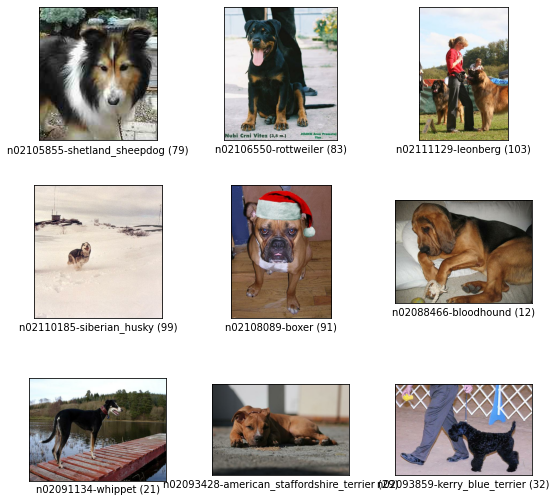

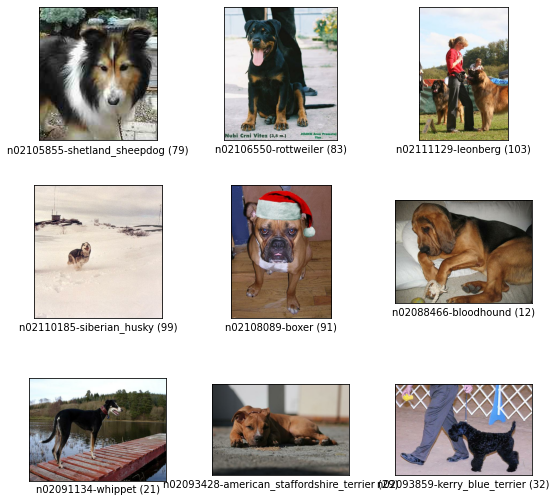

In [4]:
tfds.show_examples(ds_train, ds_info)

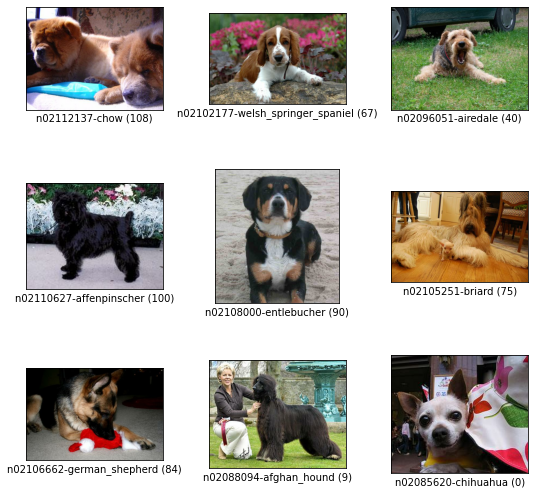

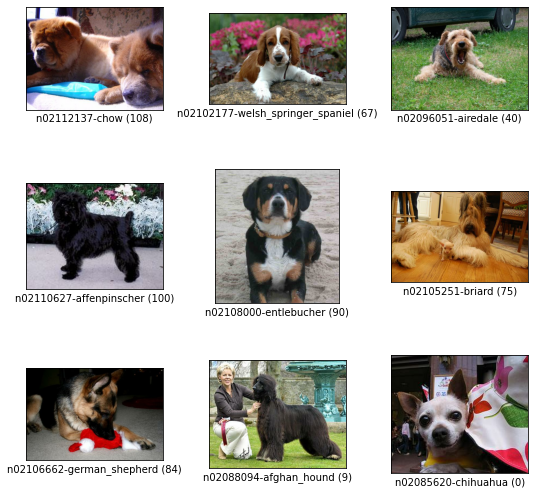

In [5]:
tfds.show_examples(ds_test, ds_info)

In [6]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

bbox(바운딩 박스)는 물체의 위치를 사각형 영역으로 표기하는 방법입니다. 위에서 확인한 바로는 BBoxFeature이라는 타입으로 정의되어 있습니다.

# Model

CAM을 얻어내기 위한 모델 미리 이미지넷(ImageNet) 데이터에 훈련된 ResNet50을 기반으로 하고, 이후 pooling layer 뒤에 소프트맥스 레이어를 붙여 Grad-CAM 모델을 만들겠습니다.

소프트맥스 레이어는 소프트맥스 함수를 활성화 함수로 사용하는 fully connected 레이어입니다.

In [7]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,    # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg',      # GAP를 적용  
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

94781440/94765736 [==============================] - 0s 0us/step


In [8]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

conv5_block3_out의 output이 feature map

In [13]:
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    '''
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    '''
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [11]:
# 데이터셋에 전처리와 배치처리를 적용합니다.
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_val_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


In [12]:
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

In [13]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_val_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 211s 210ms/step - loss: 2.2652 - accuracy: 0.4283 - val_loss: 3.3580 - val_accuracy: 0.2099
Epoch 2/20
750/750 [==============================] - 156s 207ms/step - loss: 0.6475 - accuracy: 0.8263 - val_loss: 1.3763 - val_accuracy: 0.6090
Epoch 3/20
750/750 [==============================] - 156s 208ms/step - loss: 0.1767 - accuracy: 0.9732 - val_loss: 1.0736 - val_accuracy: 0.6910
Epoch 4/20
750/750 [==============================] - 156s 208ms/step - loss: 0.0581 - accuracy: 0.9965 - val_loss: 0.9684 - val_accuracy: 0.7259
Epoch 5/20
750/750 [==============================] - 156s 208ms/step - loss: 0.0280 - accuracy: 0.9992 - val_loss: 0.9696 - val_accuracy: 0.7325
Epoch 6/20
750/750 [==============================] - 156s 209ms/step - loss: 0.0179 - accuracy: 0.9999 - val_loss: 0.9780 - val_accuracy: 0.7366
Epoch 7/20
750/750 [==============================] - 156s 208ms/step - loss: 0.0142 - accuracy: 0.9998 - val_loss: 0.9868 -

In [14]:
import os

cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model1.h5'
cam_model.save(cam_model_path)
print("저장 완료!")

/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


저장 완료!


### CAM(Class Activation Map)

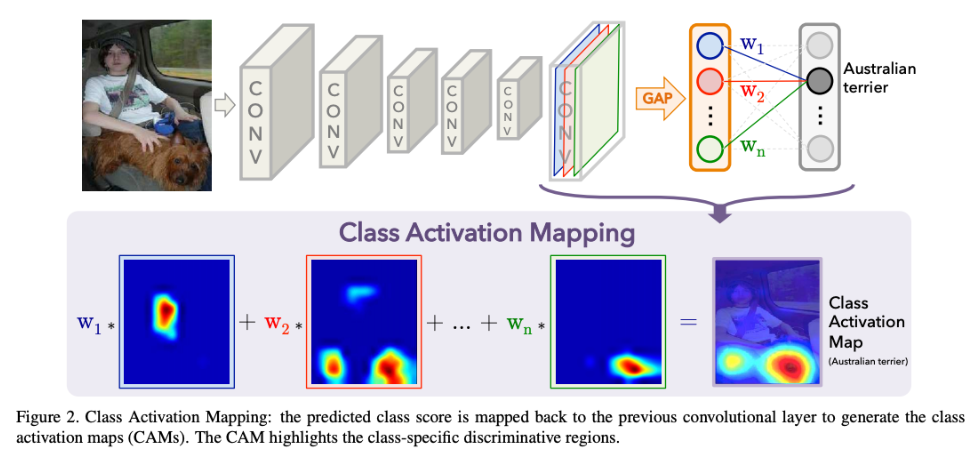

학습된 모델에서 CAM을 생성합니다. CAM 생성 작업은 데이터셋 배치 단위가 아니라 개별 이미지 데이터 단위로 이루어지기 때문에, get_one() 함수로 데이터셋에서 한 장씩 뽑을 수 있도록 했습니다.

In [7]:
import os
cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model.h5'
cam_model = tf.keras.models.load_model(cam_model_path)

In [8]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

67


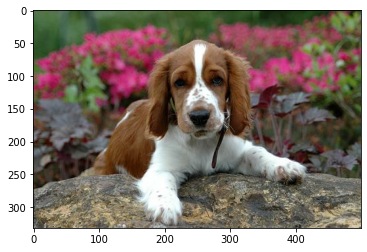

In [10]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

CAM을 생성하기 위해서는 **(1) 특성 맵**, **(2) 클래스별 확률을 얻기 위한 소프트맥스 레이어의 가중치**, 그리고 **(3) 원하는 클래스의 출력값**이 필요합니다. 또 이미지에서 모델이 어떤 부분을 보는지 직관적으로 확인하려면 네트워크에서 나온 CAM을 입력 이미지 사이즈와 같게 만들어 함께 시각화해야 할 것입니다. 이를 고려해서 model과 item을 받았을 때 입력 이미지와 동일한 크기의 CAM을 반환하는 함수를 만들어야 합니다.</br>

generate_cam() 을 구현하기 위해 아래에서는 conv_ouputs와 같이 특정 레이어의 결과값을 output으로 받기 위해 새로운 모델을 정의하고, feedforward를 거친 후 CAM을 계산하도록 구현하였습니다. 마지막에는 입력 이미지의 크기에 맞춰 CAM을 resize해 주었습니다.

In [11]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있습니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    conv_outputs = conv_outputs[0, :, :, :]
    
    # 모델의 weight activation은 마지막 layer에 있습니다.
    class_weights = model.layers[-1].get_weights()[0] 
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # conv_outputs의 i번째 채널과 i번째 weight를 곱해서 누적하면 활성화된 정도가 나타날 겁니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

GAP(Global Average Pooling) 이전의 컨볼루션 레이어의 출력을 사용하는 이유는, GAP 이후의 레이어에서는 이미지의 공간적인 정보가 상당 부분 손실되기 때문입니다. GAP은 각 채널별로 평균 값을 계산하여 공간적인 차원을 축소시키는 역할을 합니다. 따라서 GAP 이전의 출력을 사용하면 더 정확한 중요한 영역을 추출할 수 있습니다.

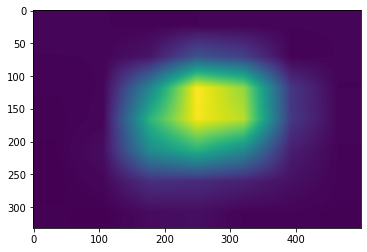

In [14]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [15]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

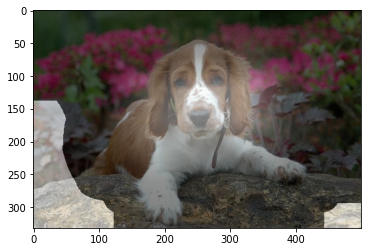

In [16]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

### Grad-CAM

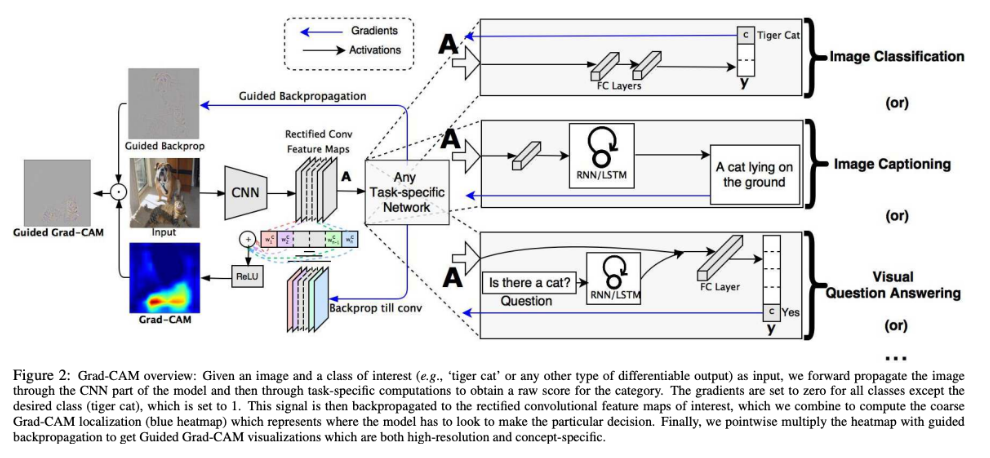

grad_cam은 관찰을 원하는 레이어와 정답 클래스에 대한 예측값 사이의 그래디언트를 구하고, 여기에 GAP 연산을 적용함으로써 관찰 대상이 되는 레이어의 채널별 가중치를 구합니다. 최종 CAM 이미지를 구하기 위해서는 레이어의 채널별 가중치(weights)와 레이어에서 나온 채널별 특성 맵을 가중합해주어 cam_image를 얻게 됩니다.

이전 스텝에서 본 CAM 함수와 달리, Grad-CAM은 이번에는 어떤 레이어든 CAM 이미지를 뽑아낼 수 있으므로, 그래디언트 계산을 원하는 관찰 대상 레이어 activation_layer를 뽑아서 쓸 수 있도록 activation_layer의 이름을 받고 이를 활용해야 합니다.

아래 generate_grad_cam()에서는 원하는 레이어의 output과 특정 클래스의 prediction 사이의 그래디언트 grad_val을 얻고 이를 weights로 활용합니다.

In [17]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # output의 k번째 채널과 k번째 weight를 곱하고 누적해서 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

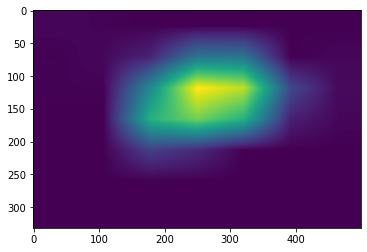

In [39]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)

plt.imshow(grad_cam_image)
plt.show()

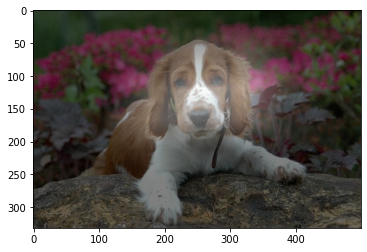

In [31]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

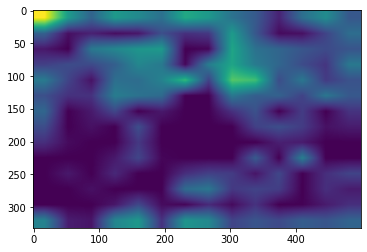

In [32]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

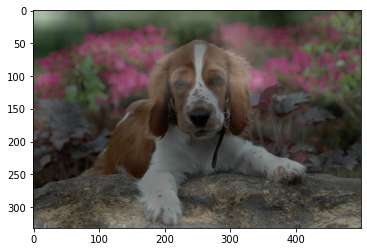

In [33]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

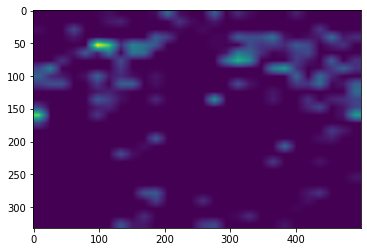

In [34]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

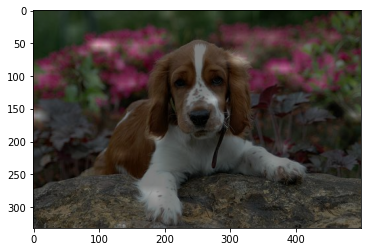

In [35]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

conv5_block3_out의 레이어가 가장 강아지부분에 위치한것으로 보인다

### 바운딩 박스

In [21]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

#### 지정된 bbox

In [73]:
xmin, ymin, xmax, ymax = item['objects']['bbox'][0]
xmin = int(xmin * item['image'].shape[0])
xmax = int(xmax * item['image'].shape[0])
ymin = int(ymin * item['image'].shape[1])
ymax = int(ymax * item['image'].shape[1])

image_box = np.array([[xmin, ymin],
             [xmax, ymin],
             [xmax, ymax],
             [xmin, ymax]])
image_box

array([[ 45,  72],
       [328,  72],
       [328, 412],
       [ 45, 412]])

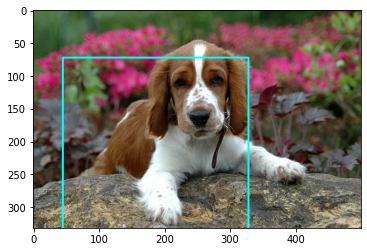

In [75]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [image_box], 0, (0,255,255), 2)
plt.imshow(image)
plt.show()

#### CAM

In [36]:
rect_cam = get_bbox(cam_image)
rect_cam

array([[111,  33],
       [443,  33],
       [443, 294],
       [111, 294]])

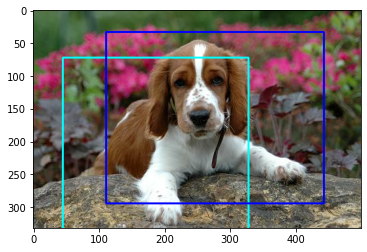

In [76]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [image_box], 0, (0,255,255), 2)
image = cv2.drawContours(image, [rect_cam], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

#### Grad_CAM

In [40]:
rect_grad_cam = get_bbox(grad_cam_image)
rect_grad_cam

array([[ 79,  72],
       [409, -27],
       [471, 172],
       [140, 273]])

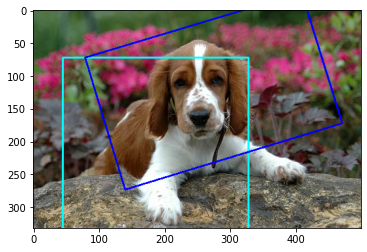

In [77]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [image_box], 0, (0,255,255), 2)
image = cv2.drawContours(image, [rect_grad_cam], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

### IoU(Intersection Over Union)

In [24]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

In [27]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [46]:
pred_bbox_cam = rect_to_minmax(rect_cam, item['image'])
pred_bbox_cam

[0.09939759036144578, 0.222, 0.8855421686746988, 0.886]

In [48]:
pred_bbox_g_cam = rect_to_minmax(rect_grad_cam, item['image'])
pred_bbox_g_cam

[-0.08132530120481928, 0.158, 0.822289156626506, 0.942]

In [49]:
item['objects']['bbox']

array([[0.13554217, 0.146     , 0.9879518 , 0.826     ]], dtype=float32)

In [50]:
get_iou(pred_bbox_cam, item['objects']['bbox'][0])

0.6983858334151163

In [51]:
get_iou(pred_bbox_g_cam, item['objects']['bbox'][0])

0.553156846572964

cam의 IoU값이 grad_cam값보다 0.14정도 높게 나왔다.

다른 그림으로도 실험해 보겠다.

23


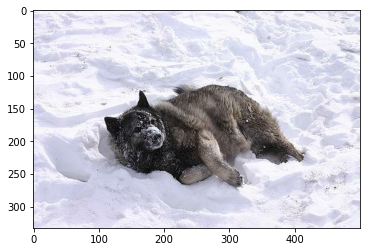

In [148]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

#### CAM

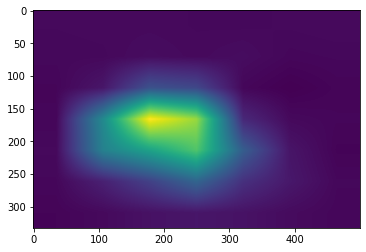

In [149]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

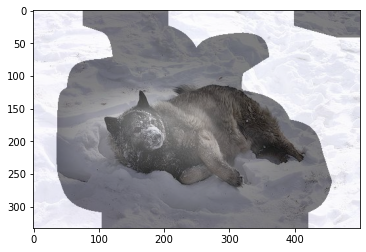

In [150]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

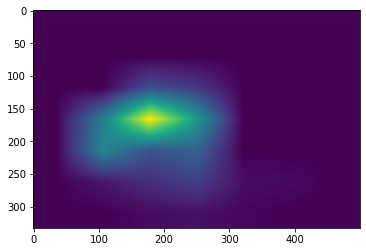

In [151]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)

plt.imshow(grad_cam_image)
plt.show()

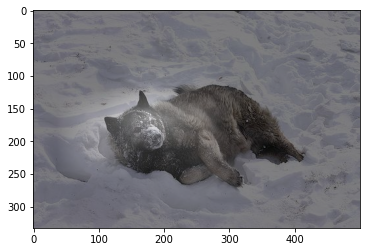

In [152]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

In [153]:
xmin, ymin, xmax, ymax = item['objects']['bbox'][0]
xmin = int(xmin * item['image'].shape[0])
xmax = int(xmax * item['image'].shape[0])
ymin = int(ymin * item['image'].shape[1])
ymax = int(ymax * item['image'].shape[1])

image_box = np.array([[xmin, ymin],
             [xmax, ymin],
             [xmax, ymax],
             [xmin, ymax]])
image_box

array([[112, 108],
       [271, 108],
       [271, 416],
       [112, 416]])

In [154]:
rect_cam = get_bbox(cam_image)
rect_cam

array([[ 38, 295],
       [ 49,  74],
       [391,  90],
       [381, 311]])

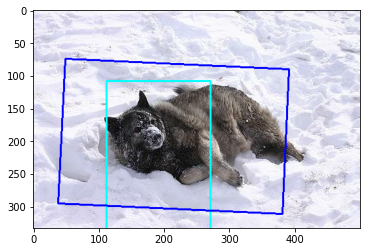

In [155]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [image_box], 0, (0,255,255), 2)
image = cv2.drawContours(image, [rect_cam], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

In [156]:
rect_grad_cam = get_bbox(grad_cam_image)
rect_grad_cam

array([[ 41, 302],
       [ 45,  77],
       [318,  83],
       [314, 308]])

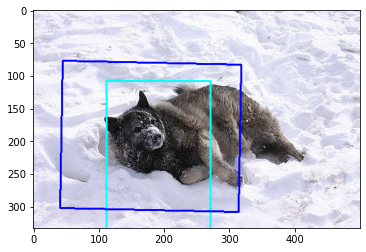

In [157]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [image_box], 0, (0,255,255), 2)
image = cv2.drawContours(image, [rect_grad_cam], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

In [158]:
pred_bbox_cam = rect_to_minmax(rect_cam, item['image'])

pred_bbox_g_cam = rect_to_minmax(rect_grad_cam, item['image'])

In [159]:
get_iou(pred_bbox_cam, item['objects']['bbox'][0])

0.5165352741867694

In [160]:
get_iou(pred_bbox_g_cam, item['objects']['bbox'][0])

0.4217555467877776

#### CAM과 Grad_CAM IoU 값 비교

|          | IoU(67) | IoU(23)       |
| ------- | ---- | ----------- |
| CAM   | 0.698   | 0.517 |
| Grad_CAM     | 0.553  | 0.422   |

두 개의 사진으로 테스트한 결과 둘다 CAM이 Grad_CAM 보다 IoU 값이 높게 나왔다.

# 회고

- CNN 이후에 GAP 과정을 거쳐 이를 softmax 적용하여 output을 얻는 CAM, grad-cam을 구현, 사용해보았다.
- 모델이 예측하는데 어떤 부분이 가장 활성화가 되어 작용하는지 시각적으로 볼 수 있었다.
- GAP를 거치기 전 마지막 레이어 뿐 아니라 그 전 레이어도 볼 수가 있었는데 마지막 레이어에 갈수록 사물에 집중되는 것 처럼 보였고 전 레이어 일수록 배경이나 여러 다른 곳을 퍼져서 보는 듯한 느낌이었다.
- 실험 결과 CAM의 iou값이 Grad-CAM의 iou 값보다 높게 나왔는데 CAM은 클래스에 대한 전역 평균 풀링을 사용하여 활성화 맵을 생성하는 반면, Grad-CAM은 클래스에 대한 그래디언트 정보를 사용하여 활성화 맵을 생성하기에 서로 다른 매커니즘이라 값이 다른듯 한것 같다.
- 그리고 뭔가 활성화 되는 부분에서 CAM의 경우가 Grad-CAM보다 전체적으로 더 넓었고 특히 

다른 사진으로 Grad-CAM을 사용하여 바운딩 박스를 만들었는데 활성화 된 부분과 바운딩 박스의 위치가 달라 의아해했었는데 찾아보니 밑에와 같은 이유 때문일수 있다고 한다.

**해석 가능성**: Grad-CAM은 모델이 클래스에 대해 어떤 부분에 집중하는지를 보여주기 때문에 모델의 관심 영역을 더 상세하게 표현할 수 있습니다. 반면에 바운딩 박스는 활성화 맵에서 일정 임계값 이상의 활성화를 가진 영역을 선택하므로, 미세한 차이로 인해 활성화 맵과 바운딩 박스의 위치가 다를 수 있습니다.

**방식의 차이**: Grad-CAM은 클래스에 대한 그래디언트 정보를 사용하여 활성화 맵을 생성하고, 이를 기반으로 바운딩 박스를 그립니다. CAM과 Grad-CAM은 서로 다른 방식으로 클래스 활성화 맵을 생성하므로, 그려지는 부분이 다를 수 있습니다.

**임계값 설정**: 바운딩 박스를 그릴 때 사용되는 임계값은 CAM 또는 Grad-CAM 결과에 따라 조정될 수 있습니다. 활성화 맵에서 특정 임계값 이상의 활성화를 가진 영역을 선택하는 방식은 사용자가 지정한 임계값에 따라 다르게 작동할 수 있습니다.